In [1]:
from diffusers import UNet2DConditionModel, DDPMScheduler, DDIMScheduler, AutoencoderKL

/home/thiendc/projects/.conda/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


RuntimeError: Failed to import diffusers.models.unets.unet_2d_condition because of the following error (look up to see its traceback):
No module named 'flash_attn.flash_attn_interface'

In [4]:
unet_model = UNet2DConditionModel()

In [12]:
unet_model

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

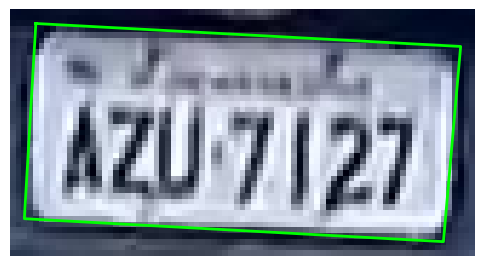

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

bbox = {
      "top-left": [4, 2],
      "top-right": [78, 6],
      "bottom-right": [75, 40],
      "bottom-left": [2, 36]
    }

# Load image (OpenCV đọc BGR)
img = cv2.imread("/home/thiendc/projects/icpr/dataset/train/Scenario-A/Brazilian/track_00002/hr-001.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert sang RGB cho matplotlib

# Bounding box points
points = np.array([
    bbox["top-left"],
    bbox["top-right"],
    bbox["bottom-right"],
    bbox["bottom-left"],
    bbox["top-left"]  # đóng polygon
])

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.plot(points[:, 0], points[:, 1], color='lime', linewidth=2)
plt.axis("off")
plt.show()


Đang xử lý với tất cả các phương pháp...
Hoàn thành!

Hiển thị tất cả kết quả...
Đã lưu kết quả vào 'plate_enhancement_results.png'


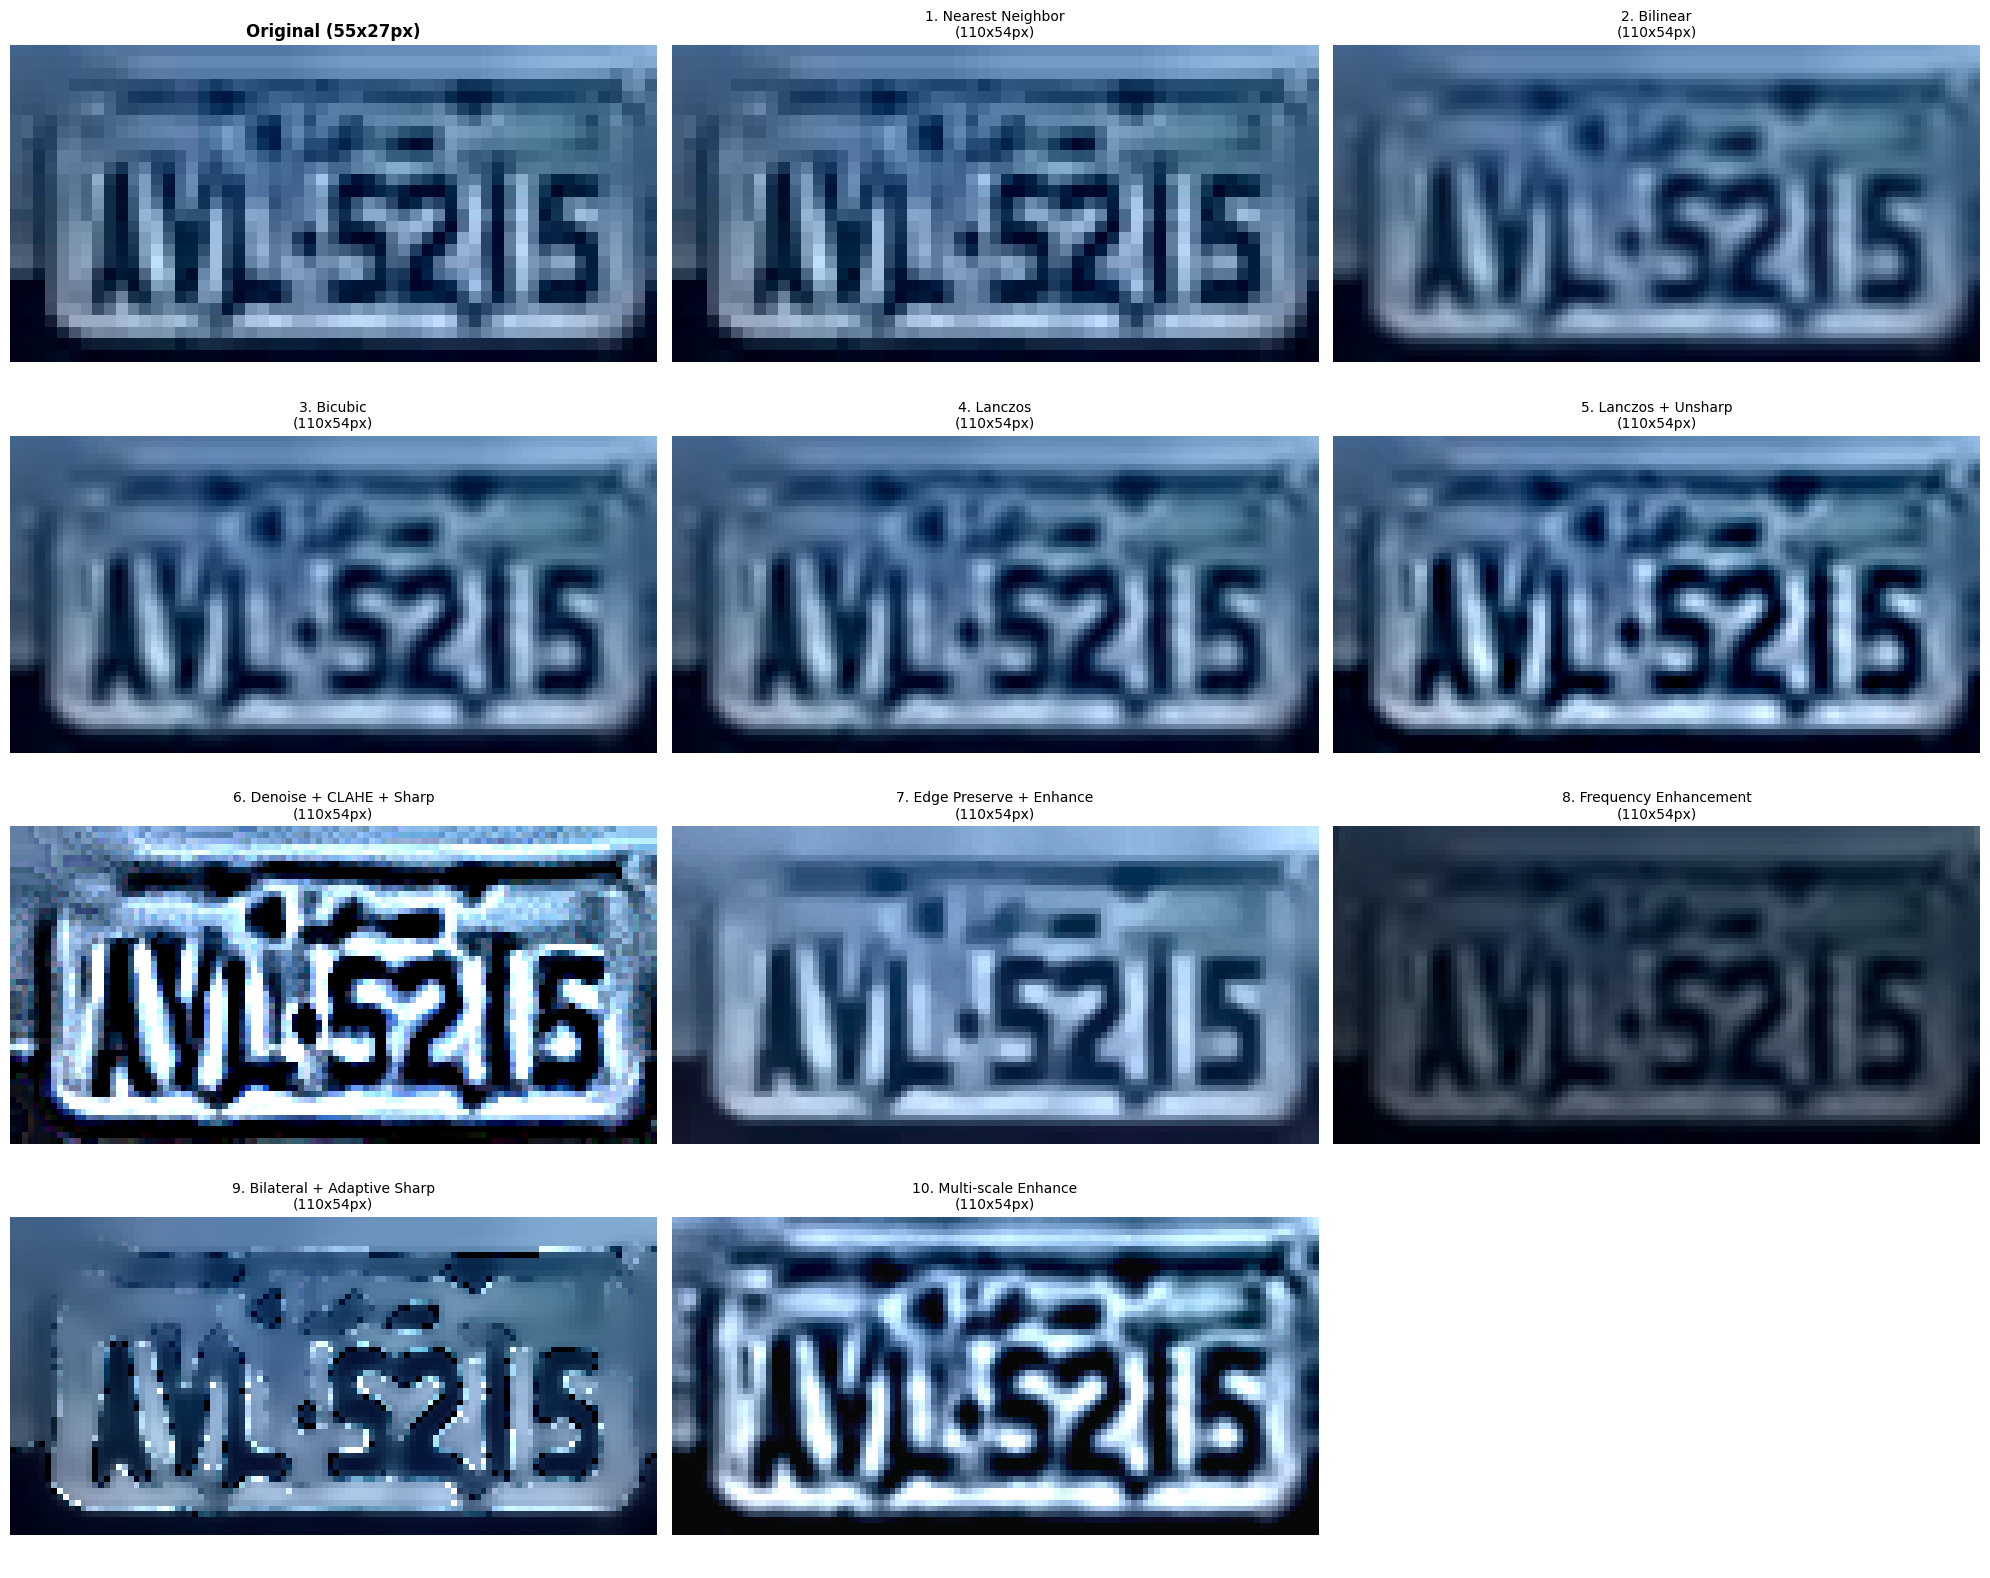


So sánh các phương pháp tốt nhất...
Đã lưu so sánh vào 'plate_best_methods.png'


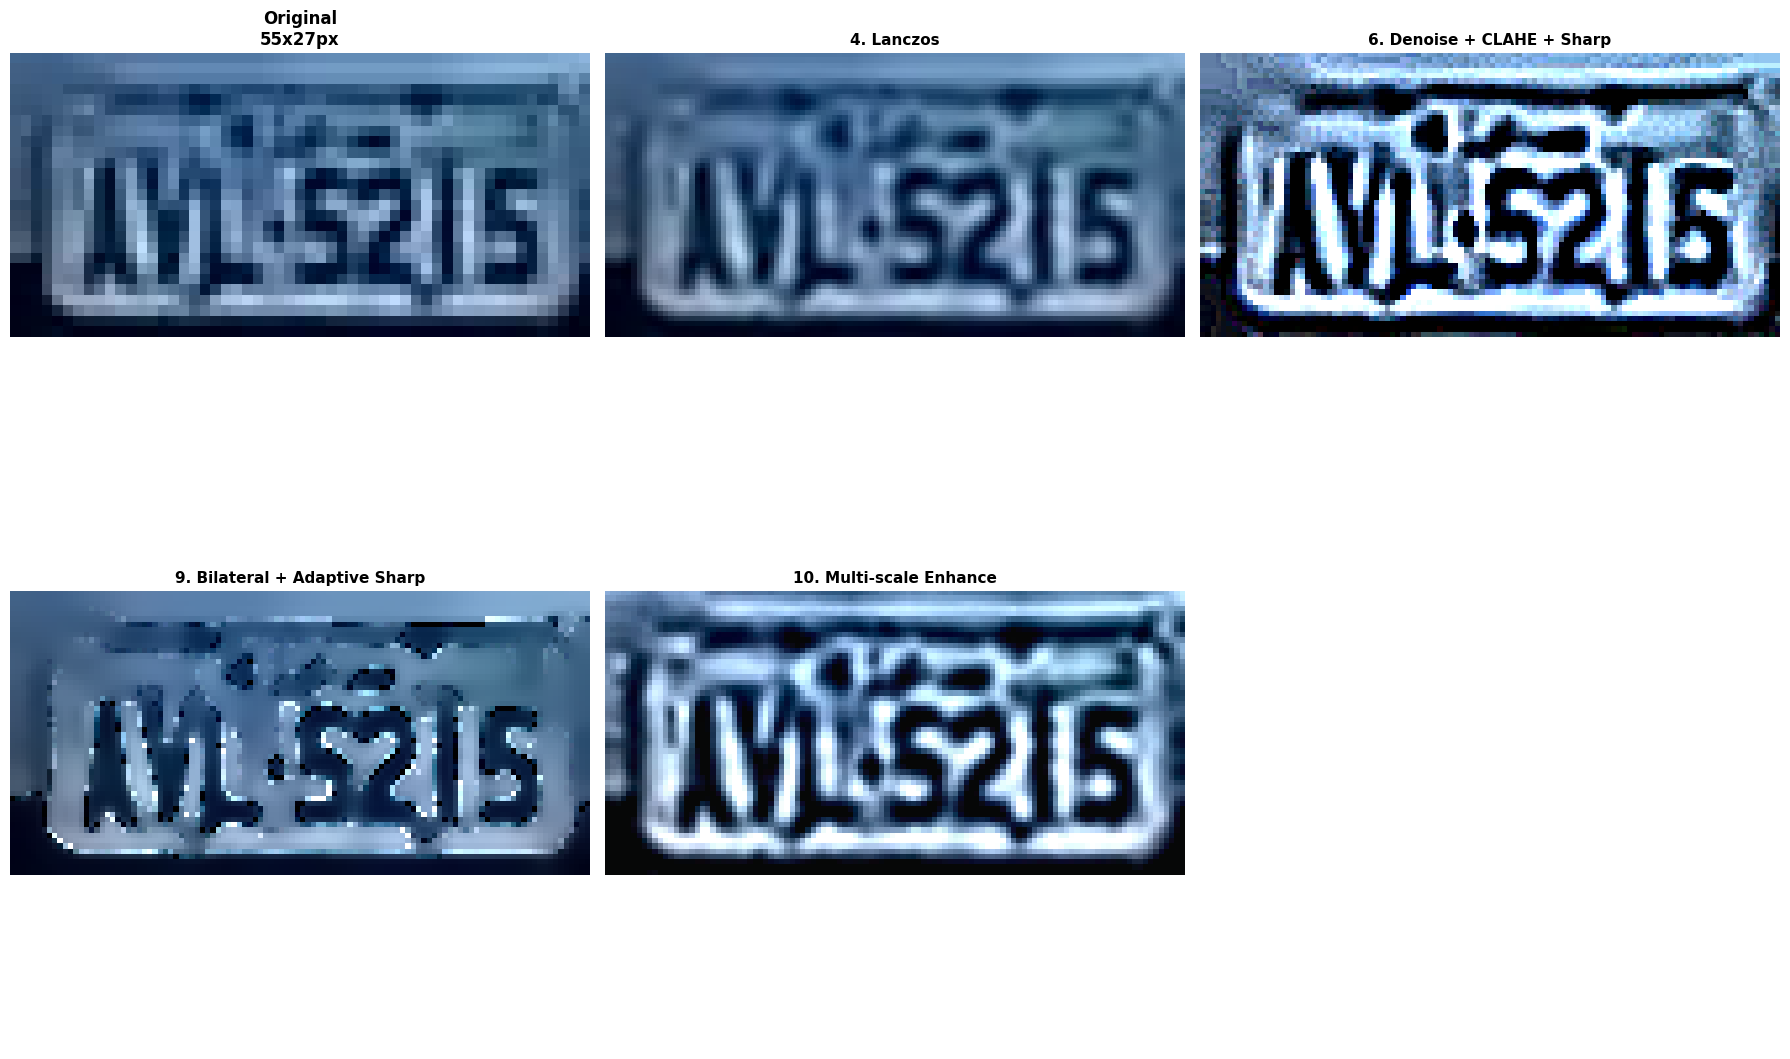

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image, ImageFilter, ImageEnhance

class PlateEnhancer:
    def __init__(self, img_path=None, img_array=None):
        """
        Khởi tạo với đường dẫn ảnh hoặc numpy array
        """
        if img_path:
            self.original = cv2.imread(img_path)
            if self.original is None:
                raise ValueError(f"Không thể đọc ảnh từ {img_path}")
            self.original = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        elif img_array is not None:
            self.original = img_array
        else:
            raise ValueError("Cần cung cấp img_path hoặc img_array")
        
        self.results = {}
        
    def method_1_nearest(self, scale=8):
        """Phương pháp 1: Nearest Neighbor - nhanh nhất, giữ nguyên pixel"""
        result = cv2.resize(self.original, None, fx=scale, fy=scale, 
                          interpolation=cv2.INTER_NEAREST)
        self.results['1. Nearest Neighbor'] = result
        return result
    
    def method_2_bilinear(self, scale=8):
        """Phương pháp 2: Bilinear - mượt hơn nearest"""
        result = cv2.resize(self.original, None, fx=scale, fy=scale, 
                          interpolation=cv2.INTER_LINEAR)
        self.results['2. Bilinear'] = result
        return result
    
    def method_3_bicubic(self, scale=8):
        """Phương pháp 3: Bicubic - sắc nét hơn bilinear"""
        result = cv2.resize(self.original, None, fx=scale, fy=scale, 
                          interpolation=cv2.INTER_CUBIC)
        self.results['3. Bicubic'] = result
        return result
    
    def method_4_lanczos(self, scale=8):
        """Phương pháp 4: Lanczos - chất lượng cao nhất trong interpolation"""
        result = cv2.resize(self.original, None, fx=scale, fy=scale, 
                          interpolation=cv2.INTER_LANCZOS4)
        self.results['4. Lanczos'] = result
        return result
    
    def method_5_unsharp_mask(self, scale=8):
        """Phương pháp 5: Lanczos + Unsharp Masking"""
        # Phóng to
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Áp dụng Unsharp Mask
        gaussian = cv2.GaussianBlur(upscaled, (0, 0), 2.0)
        result = cv2.addWeighted(upscaled, 1.5, gaussian, -0.5, 0)
        result = np.clip(result, 0, 255).astype(np.uint8)
        
        self.results['5. Lanczos + Unsharp'] = result
        return result
    
    def method_6_denoising_sharpening(self, scale=8):
        """Phương pháp 6: Denoising + CLAHE + Sharpening"""
        # Phóng to
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Giảm nhiễu
        denoised = cv2.fastNlMeansDenoisingColored(upscaled, None, 10, 10, 7, 21)
        
        # CLAHE trên mỗi kênh màu
        lab = cv2.cvtColor(denoised, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        
        # Sharpening
        kernel = np.array([[-1,-1,-1],
                          [-1, 9,-1],
                          [-1,-1,-1]])
        result = cv2.filter2D(enhanced, -1, kernel)
        result = np.clip(result, 0, 255).astype(np.uint8)
        
        self.results['6. Denoise + CLAHE + Sharp'] = result
        return result
    
    def method_7_edge_enhancement(self, scale=8):
        """Phương pháp 7: Edge-Preserving Filter + Enhancement"""
        # Phóng to
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Edge-preserving filter
        filtered = cv2.edgePreservingFilter(upscaled, flags=1, sigma_s=60, sigma_r=0.4)
        
        # Tăng contrast
        lab = cv2.cvtColor(filtered, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        result = cv2.merge([l, a, b])
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
        
        self.results['7. Edge Preserve + Enhance'] = result
        return result
    
    def method_8_frequency_enhancement(self, scale=8):
        """Phương pháp 8: Frequency Domain Enhancement"""
        # Phóng to
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Xử lý từng kênh màu
        result = np.zeros_like(upscaled)
        for i in range(3):
            # FFT
            f = np.fft.fft2(upscaled[:,:,i])
            fshift = np.fft.fftshift(f)
            
            # Tăng cường tần số cao (high-pass filter)
            rows, cols = upscaled.shape[:2]
            crow, ccol = rows//2, cols//2
            
            # Tạo mask tăng cường tần số cao
            mask = np.ones((rows, cols), np.float32)
            r = 30
            center = [crow, ccol]
            x, y = np.ogrid[:rows, :cols]
            mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
            mask[mask_area] = 0.5  # Giảm tần số thấp
            
            fshift = fshift * mask
            
            # IFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = np.fft.ifft2(f_ishift)
            img_back = np.abs(img_back)
            
            result[:,:,i] = img_back
        
        result = np.clip(result, 0, 255).astype(np.uint8)
        self.results['8. Frequency Enhancement'] = result
        return result
    
    def method_9_adaptive_bilateral(self, scale=8):
        """Phương pháp 9: Bilateral Filter + Adaptive Sharpening"""
        # Phóng to
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Bilateral filter (giữ edge, giảm nhiễu)
        bilateral = cv2.bilateralFilter(upscaled, 9, 75, 75)
        
        # Adaptive sharpening dựa trên edge
        gray = cv2.cvtColor(bilateral, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edges = edges.astype(float) / 255.0
        
        # Sharpen mạnh hơn ở vùng có edge
        kernel = np.array([[-1,-1,-1],
                          [-1, 9,-1],
                          [-1,-1,-1]]) / 1.0
        sharpened = cv2.filter2D(bilateral, -1, kernel)
        
        # Blend dựa trên edge map
        edges_3ch = np.stack([edges, edges, edges], axis=2)
        result = bilateral * (1 - edges_3ch) + sharpened * edges_3ch
        result = np.clip(result, 0, 255).astype(np.uint8)
        
        self.results['9. Bilateral + Adaptive Sharp'] = result
        return result
    
    def method_10_multi_scale(self, scale=8):
        """Phương pháp 10: Multi-scale Enhancement"""
        # Phóng to từng bước
        current = self.original.copy()
        target_scale = scale
        
        # Phóng to dần 2x mỗi lần
        while target_scale > 1:
            step = min(2, target_scale)
            current = cv2.resize(current, None, fx=step, fy=step, 
                               interpolation=cv2.INTER_LANCZOS4)
            
            # Enhance ở mỗi scale
            current = cv2.detailEnhance(current, sigma_s=10, sigma_r=0.15)
            
            target_scale /= step
        
        # Final enhancement
        lab = cv2.cvtColor(current, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        l = clahe.apply(l)
        result = cv2.merge([l, a, b])
        result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
        
        self.results['10. Multi-scale Enhance'] = result
        return result
    
    def run_all_methods(self, scale=8):
        """Chạy tất cả các phương pháp"""
        print("Đang xử lý với tất cả các phương pháp...")
        self.method_1_nearest(scale)
        self.method_2_bilinear(scale)
        self.method_3_bicubic(scale)
        self.method_4_lanczos(scale)
        self.method_5_unsharp_mask(scale)
        self.method_6_denoising_sharpening(scale)
        self.method_7_edge_enhancement(scale)
        self.method_8_frequency_enhancement(scale)
        self.method_9_adaptive_bilateral(scale)
        self.method_10_multi_scale(scale)
        print("Hoàn thành!")
        return self.results
    
    def visualize_all(self, figsize=(20, 16)):
        """Visualize tất cả kết quả"""
        if not self.results:
            print("Chưa có kết quả. Chạy run_all_methods() trước.")
            return
        
        n_methods = len(self.results) + 1  # +1 cho ảnh gốc
        cols = 3
        rows = (n_methods + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        
        # Hiển thị ảnh gốc
        axes[0].imshow(self.original)
        axes[0].set_title(f'Original ({self.original.shape[1]}x{self.original.shape[0]}px)', 
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Hiển thị các kết quả
        for idx, (method_name, result) in enumerate(self.results.items(), 1):
            axes[idx].imshow(result)
            axes[idx].set_title(f'{method_name}\n({result.shape[1]}x{result.shape[0]}px)', 
                               fontsize=10)
            axes[idx].axis('off')
        
        # Ẩn các subplot thừa
        for idx in range(n_methods, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('plate_enhancement_results.png', dpi=150, bbox_inches='tight')
        print("Đã lưu kết quả vào 'plate_enhancement_results.png'")
        plt.show()
    
    def compare_best_methods(self, methods=['4. Lanczos', '6. Denoise + CLAHE + Sharp', 
                                           '9. Bilateral + Adaptive Sharp', '10. Multi-scale Enhance']):
        """So sánh chi tiết các phương pháp tốt nhất"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Ảnh gốc
        axes[0].imshow(self.original)
        axes[0].set_title(f'Original\n{self.original.shape[1]}x{self.original.shape[0]}px', 
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # Các phương pháp được chọn
        for idx, method_name in enumerate(methods, 1):
            if method_name in self.results:
                axes[idx].imshow(self.results[method_name])
                axes[idx].set_title(method_name, fontsize=11, fontweight='bold')
                axes[idx].axis('off')
        
        # Ẩn subplot thừa
        if len(methods) < 5:
            axes[5].axis('off')
        
        plt.tight_layout()
        plt.savefig('plate_best_methods.png', dpi=150, bbox_inches='tight')
        print("Đã lưu so sánh vào 'plate_best_methods.png'")
        plt.show()


# Ví dụ sử dụng
if __name__ == "__main__":
    # Tạo ảnh demo giả lập biển số xe nhỏ 30x18
    # print("Tạo ảnh demo...")
    # demo_img = np.ones((18, 30, 3), dtype=np.uint8) * 240
    
    # # Vẽ text giả lập
    # cv2.putText(demo_img, '29A', (2, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
    # cv2.putText(demo_img, '12345', (2, 16), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 0, 0), 1)
    
    # # Thêm noise
    # noise = np.random.normal(0, 10, demo_img.shape)
    # demo_img = np.clip(demo_img + noise, 0, 255).astype(np.uint8)
    
    # Khởi tạo enhancer
    enhancer = PlateEnhancer(img_path='/home/thiendc/projects/icpr/dataset/train/Scenario-A/Brazilian/track_00001/hr-005.png')
    
    # Chạy tất cả phương pháp
    results = enhancer.run_all_methods(scale=2)
    
    # Visualize
    print("\nHiển thị tất cả kết quả...")
    enhancer.visualize_all()
    
    print("\nSo sánh các phương pháp tốt nhất...")
    enhancer.compare_best_methods()

Đang xử lý với tất cả các phương pháp...

Đang tính toán OCR metrics...
Hoàn thành!

BẢNG XẾP HẠNG PHƯƠNG PHÁP CHO OCR (theo OCR Score)
Rank   Method                         OCR Score    Sharpness    Contrast  
--------------------------------------------------------------------------------
1      10. Multi-scale Text           10.5119      50218.5      1.000     
2      5. Edge-based Text             8.9716       42604.9      1.000     
3      3. Adaptive Threshold          8.8447       41927.5      1.000     
4      8. Niblack Binarization        7.1188       33319.5      1.000     
5      9. OCR Optimized Pipeline      5.3535       24531.1      1.000     
6      4. Morphology Text             4.5217       20393.7      1.000     
7      7. Sauvola Binarization        4.4284       19947.8      1.000     
8      2. Otsu Binarization           3.9973       17785.9      1.000     
9      6. Contrast Stretching         1.3280       3907.5       1.000     
10     1. Lanczos Basic          

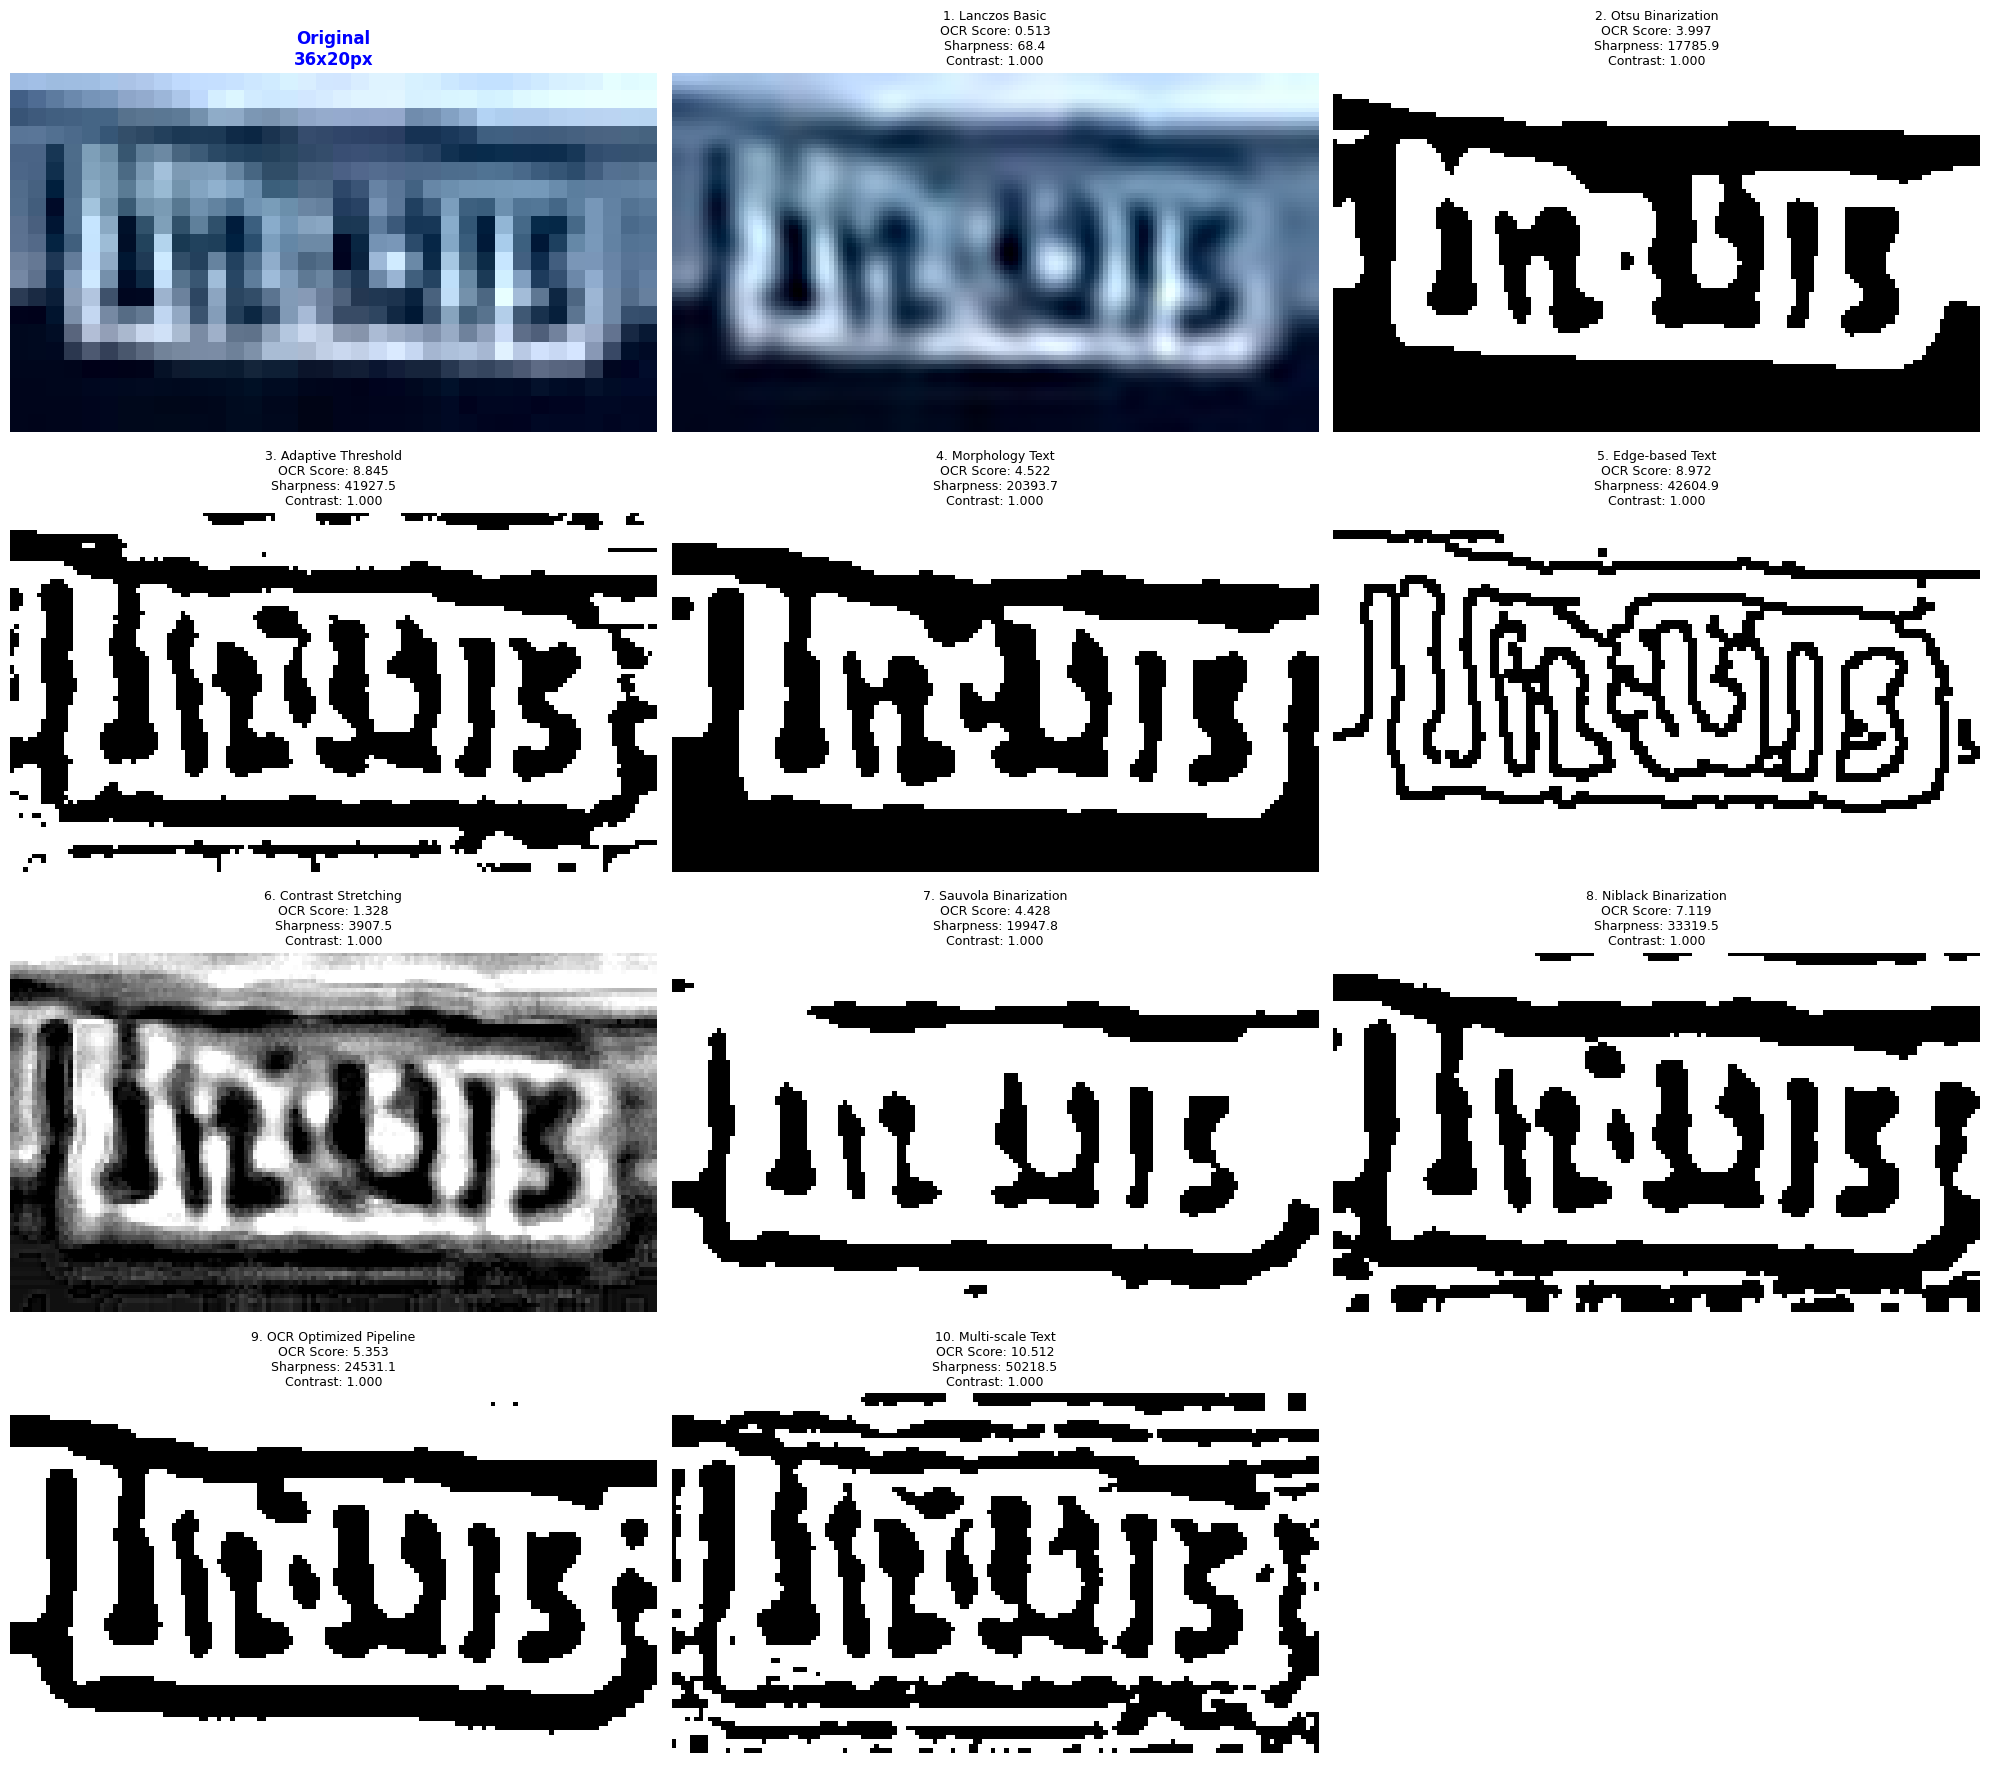

Đã lưu so sánh metrics vào 'ocr_metrics_comparison.png'


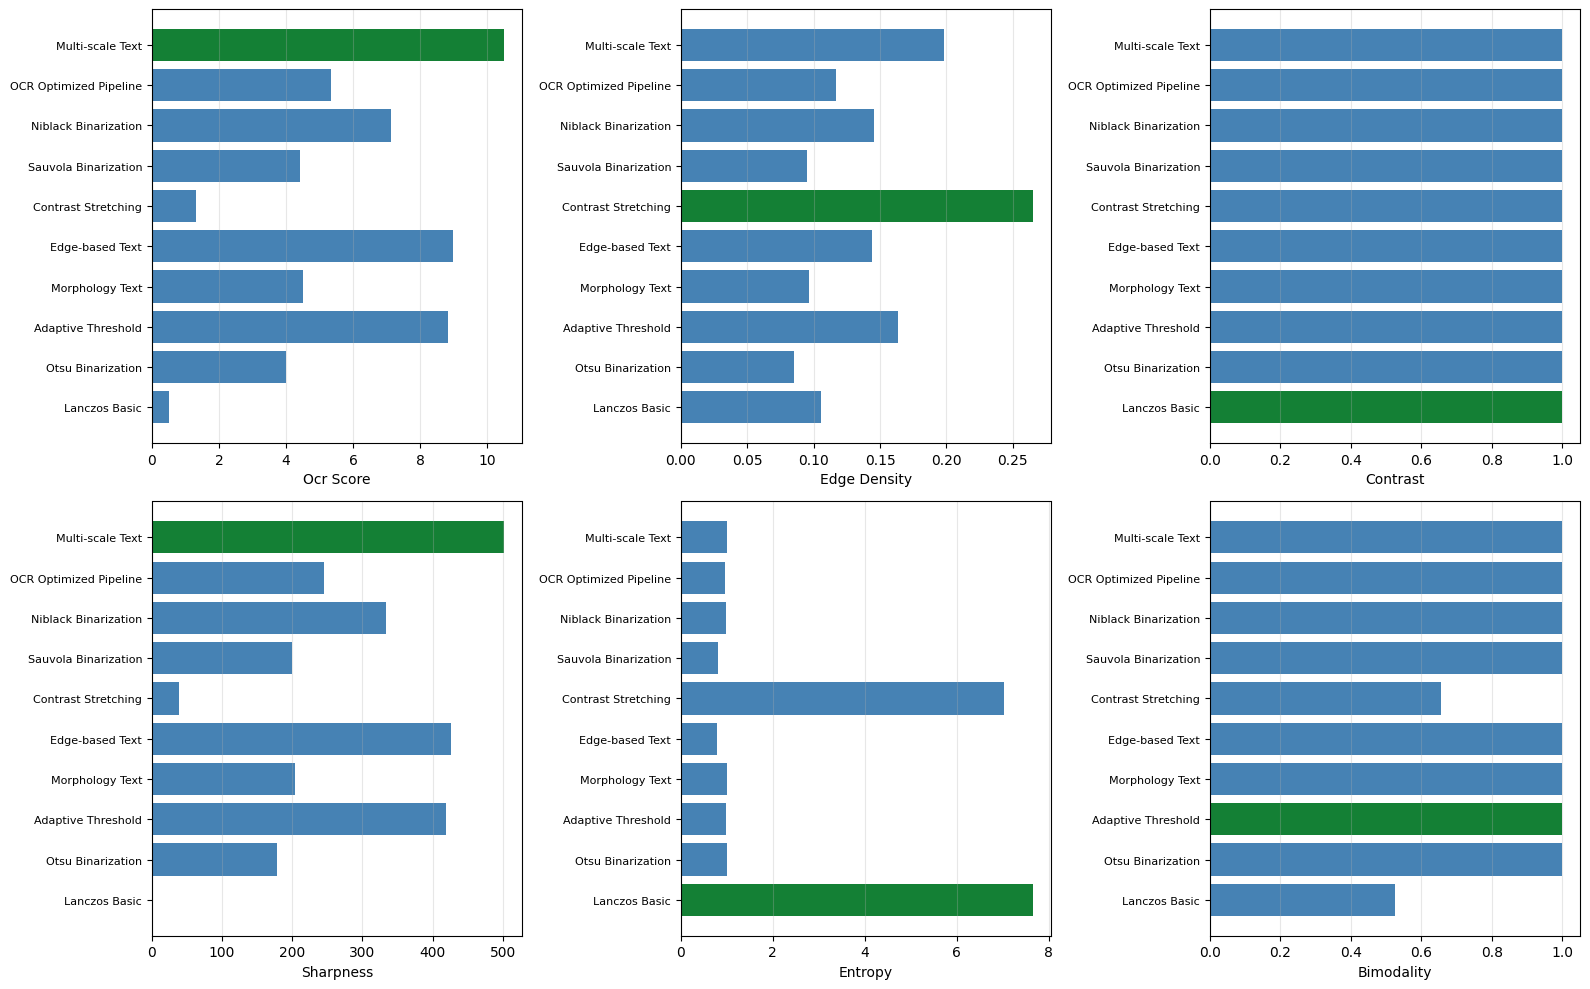

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image, ImageFilter, ImageEnhance
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import warnings
warnings.filterwarnings('ignore')

class PlateEnhancerForOCR:
    def __init__(self, img_path=None, img_array=None):
        """
        Khởi tạo với đường dẫn ảnh hoặc numpy array
        """
        if img_path:
            self.original = cv2.imread(img_path)
            if self.original is None:
                raise ValueError(f"Không thể đọc ảnh từ {img_path}")
            self.original = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        elif img_array is not None:
            self.original = img_array
        else:
            raise ValueError("Cần cung cấp img_path hoặc img_array")
        
        self.results = {}
        self.metrics = {}
        
    # ============ PHƯƠNG PHÁP CƠ BẢN ============
    
    def method_1_lanczos_basic(self, scale=8):
        """Phương pháp 1: Lanczos cơ bản"""
        result = cv2.resize(self.original, None, fx=scale, fy=scale, 
                          interpolation=cv2.INTER_LANCZOS4)
        self.results['1. Lanczos Basic'] = result
        return result
    
    # ============ PHƯƠNG PHÁP CHO TEXT/OCR ============
    
    def method_2_binarization_otsu(self, scale=8):
        """Phương pháp 2: Otsu Binarization - tốt cho OCR"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        # Chuyển sang grayscale
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # Giảm nhiễu
        denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
        
        # Otsu thresholding
        _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        self.results['2. Otsu Binarization'] = result
        return result
    
    def method_3_adaptive_threshold(self, scale=8):
        """Phương pháp 3: Adaptive Thresholding - tốt cho text không đều sáng"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # CLAHE để cân bằng sáng
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Adaptive threshold
        binary = cv2.adaptiveThreshold(enhanced, 255, 
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        self.results['3. Adaptive Threshold'] = result
        return result
    
    def method_4_morphology_text(self, scale=8):
        """Phương pháp 4: Morphological Operations - làm rõ text"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Binarization
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morphological closing để nối các phần text
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        
        # Opening để loại noise
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
        
        result = cv2.cvtColor(opened, cv2.COLOR_GRAY2RGB)
        self.results['4. Morphology Text'] = result
        return result
    
    def method_5_stroke_width_transform(self, scale=8):
        """Phương pháp 5: Edge-based Text Enhancement"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # Bilateral filter để giữ edge
        filtered = cv2.bilateralFilter(gray, 9, 75, 75)
        
        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
        enhanced = clahe.apply(filtered)
        
        # Canny edge
        edges = cv2.Canny(enhanced, 50, 150)
        
        # Dilate edges
        kernel = np.ones((2,2), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=1)
        
        # Invert
        inverted = cv2.bitwise_not(dilated)
        
        result = cv2.cvtColor(inverted, cv2.COLOR_GRAY2RGB)
        self.results['5. Edge-based Text'] = result
        return result
    
    def method_6_contrast_stretching(self, scale=8):
        """Phương pháp 6: Contrast Stretching cho text"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # Normalize về [0, 255]
        normalized = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
        
        # CLAHE mạnh
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        enhanced = clahe.apply(normalized)
        
        # Sharpening
        kernel = np.array([[-1,-1,-1],
                          [-1, 9,-1],
                          [-1,-1,-1]])
        sharpened = cv2.filter2D(enhanced, -1, kernel)
        
        result = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2RGB)
        self.results['6. Contrast Stretching'] = result
        return result
    
    def method_7_sauvola_binarization(self, scale=8):
        """Phương pháp 7: Sauvola Binarization - tốt cho text độ tương phản thấp"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY).astype(np.float64)
        
        # Sauvola thresholding
        window_size = 15
        k = 0.5
        R = 128
        
        # Tính mean và std trong window
        mean = cv2.boxFilter(gray, -1, (window_size, window_size))
        sqr_mean = cv2.boxFilter(gray**2, -1, (window_size, window_size))
        std = np.sqrt(sqr_mean - mean**2)
        
        threshold = mean * (1 + k * ((std / R) - 1))
        binary = (gray > threshold).astype(np.uint8) * 255
        
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        self.results['7. Sauvola Binarization'] = result
        return result
    
    def method_8_niblack_binarization(self, scale=8):
        """Phương pháp 8: Niblack Binarization"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY).astype(np.float64)
        
        # Niblack thresholding
        window_size = 15
        k = -0.2
        
        mean = cv2.boxFilter(gray, -1, (window_size, window_size))
        sqr_mean = cv2.boxFilter(gray**2, -1, (window_size, window_size))
        std = np.sqrt(sqr_mean - mean**2)
        
        threshold = mean + k * std
        binary = (gray > threshold).astype(np.uint8) * 255
        
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        self.results['8. Niblack Binarization'] = result
        return result
    
    def method_9_text_optimized_pipeline(self, scale=8):
        """Phương pháp 9: Pipeline tối ưu cho OCR"""
        upscaled = cv2.resize(self.original, None, fx=scale, fy=scale, 
                            interpolation=cv2.INTER_LANCZOS4)
        
        gray = cv2.cvtColor(upscaled, cv2.COLOR_RGB2GRAY)
        
        # 1. Denoising
        denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
        
        # 2. CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)
        
        # 3. Bilateral filter
        filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
        
        # 4. Adaptive threshold
        binary = cv2.adaptiveThreshold(filtered, 255, 
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
        # 5. Morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
        
        result = cv2.cvtColor(opened, cv2.COLOR_GRAY2RGB)
        self.results['9. OCR Optimized Pipeline'] = result
        return result
    
    def method_10_multi_scale_text(self, scale=8):
        """Phương pháp 10: Multi-scale với tối ưu cho text"""
        current = self.original.copy()
        target_scale = scale
        
        while target_scale > 1:
            step = min(2, target_scale)
            current = cv2.resize(current, None, fx=step, fy=step, 
                               interpolation=cv2.INTER_LANCZOS4)
            
            # Enhance cho text ở mỗi scale
            gray = cv2.cvtColor(current, cv2.COLOR_RGB2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            enhanced = clahe.apply(gray)
            current = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
            
            target_scale /= step
        
        # Final processing
        gray = cv2.cvtColor(current, cv2.COLOR_RGB2GRAY)
        binary = cv2.adaptiveThreshold(gray, 255, 
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        
        result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        self.results['10. Multi-scale Text'] = result
        return result
    
    # ============ METRICS CHO OCR ============
    
    def calculate_ocr_metrics(self, img):
        """Tính các metrics quan trọng cho OCR"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
        
        metrics = {}
        
        # 1. Edge Density - Nhiều edge = text rõ hơn
        edges = cv2.Canny(gray, 50, 150)
        metrics['edge_density'] = np.sum(edges > 0) / edges.size
        
        # 2. Contrast (Michelson Contrast)
        I_max = np.max(gray)
        I_min = np.min(gray)
        if I_max + I_min > 0:
            metrics['contrast'] = (I_max - I_min) / (I_max + I_min)
        else:
            metrics['contrast'] = 0
        
        # 3. Sharpness (Laplacian Variance) - Cao hơn = sắc nét hơn
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        metrics['sharpness'] = laplacian.var()
        
        # 4. Entropy - Thông tin trong ảnh
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        hist = hist[hist > 0]
        metrics['entropy'] = -np.sum(hist * np.log2(hist))
        
        # 5. Text-like Structure (Horizontal/Vertical edge ratio)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        horizontal_edges = np.sum(np.abs(sobelx))
        vertical_edges = np.sum(np.abs(sobely))
        if vertical_edges > 0:
            metrics['edge_orientation_ratio'] = horizontal_edges / vertical_edges
        else:
            metrics['edge_orientation_ratio'] = 0
        
        # 6. Binarization Quality (Bimodality)
        hist, _ = np.histogram(gray, bins=256, range=(0, 256))
        hist = hist.astype(float)
        hist = hist / hist.sum()
        
        # Tính bimodality coefficient
        n = len(gray.flatten())
        mean = np.mean(gray)
        std = np.std(gray)
        skew = np.sum(((gray.flatten() - mean) / std) ** 3) / n
        kurt = np.sum(((gray.flatten() - mean) / std) ** 4) / n
        metrics['bimodality'] = (skew**2 + 1) / kurt
        
        # 7. OCR-friendly Score (composite)
        # Kết hợp các metrics quan trọng
        metrics['ocr_score'] = (
            metrics['edge_density'] * 0.25 +
            metrics['contrast'] * 0.25 +
            (metrics['sharpness'] / 1000) * 0.2 +  # Normalize
            (metrics['entropy'] / 8) * 0.15 +  # Normalize
            min(metrics['bimodality'], 1) * 0.15
        )
        
        return metrics
    
    def run_all_methods(self, scale=8):
        """Chạy tất cả các phương pháp và tính metrics"""
        print("Đang xử lý với tất cả các phương pháp...")
        
        methods = [
            self.method_1_lanczos_basic,
            self.method_2_binarization_otsu,
            self.method_3_adaptive_threshold,
            self.method_4_morphology_text,
            self.method_5_stroke_width_transform,
            self.method_6_contrast_stretching,
            self.method_7_sauvola_binarization,
            self.method_8_niblack_binarization,
            self.method_9_text_optimized_pipeline,
            self.method_10_multi_scale_text
        ]
        
        for method in methods:
            method(scale)
        
        # Tính metrics cho mỗi phương pháp
        print("\nĐang tính toán OCR metrics...")
        for name, img in self.results.items():
            self.metrics[name] = self.calculate_ocr_metrics(img)
        
        print("Hoàn thành!")
        return self.results
    
    def get_best_methods_by_metric(self, metric_name='ocr_score', top_n=3):
        """Lấy top N phương pháp tốt nhất theo metric"""
        if not self.metrics:
            print("Chưa có metrics. Chạy run_all_methods() trước.")
            return []
        
        sorted_methods = sorted(self.metrics.items(), 
                              key=lambda x: x[1][metric_name], 
                              reverse=True)
        
        return sorted_methods[:top_n]
    
    def visualize_all(self, figsize=(20, 18)):
        """Visualize tất cả kết quả với metrics"""
        if not self.results:
            print("Chưa có kết quả. Chạy run_all_methods() trước.")
            return
        
        n_methods = len(self.results) + 1
        cols = 3
        rows = (n_methods + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        
        # Hiển thị ảnh gốc
        axes[0].imshow(self.original)
        axes[0].set_title(f'Original\n{self.original.shape[1]}x{self.original.shape[0]}px', 
                         fontsize=12, fontweight='bold', color='blue')
        axes[0].axis('off')
        
        # Hiển thị các kết quả với metrics
        for idx, (method_name, result) in enumerate(self.results.items(), 1):
            axes[idx].imshow(result)
            
            # Lấy metrics
            if method_name in self.metrics:
                m = self.metrics[method_name]
                title = f'{method_name}\n'
                title += f'OCR Score: {m["ocr_score"]:.3f}\n'
                title += f'Sharpness: {m["sharpness"]:.1f}\n'
                title += f'Contrast: {m["contrast"]:.3f}'
            else:
                title = method_name
            
            axes[idx].set_title(title, fontsize=9)
            axes[idx].axis('off')
        
        # Ẩn các subplot thừa
        for idx in range(n_methods, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig('ocr_enhancement_results.png', dpi=150, bbox_inches='tight')
        print("Đã lưu kết quả vào 'ocr_enhancement_results.png'")
        plt.show()
    
    def visualize_metrics_comparison(self, figsize=(16, 10)):
        """Visualize so sánh metrics"""
        if not self.metrics:
            print("Chưa có metrics.")
            return
        
        metrics_to_plot = ['ocr_score', 'edge_density', 'contrast', 
                          'sharpness', 'entropy', 'bimodality']
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()
        
        methods = list(self.metrics.keys())
        
        for idx, metric in enumerate(metrics_to_plot):
            values = [self.metrics[m][metric] for m in methods]
            
            # Normalize sharpness để dễ nhìn
            if metric == 'sharpness':
                values = [v / 100 for v in values]
            
            axes[idx].barh(range(len(methods)), values, color='steelblue')
            axes[idx].set_yticks(range(len(methods)))
            axes[idx].set_yticklabels([m.split('.')[1].strip() for m in methods], fontsize=8)
            axes[idx].set_xlabel(metric.replace('_', ' ').title())
            axes[idx].grid(axis='x', alpha=0.3)
            
            # Highlight best
            best_idx = np.argmax(values)
            axes[idx].barh(best_idx, values[best_idx], color='green', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig('ocr_metrics_comparison.png', dpi=150, bbox_inches='tight')
        print("Đã lưu so sánh metrics vào 'ocr_metrics_comparison.png'")
        plt.show()
    
    def print_ranking(self):
        """In bảng xếp hạng theo OCR score"""
        if not self.metrics:
            print("Chưa có metrics.")
            return
        
        print("\n" + "="*80)
        print("BẢNG XẾP HẠNG PHƯƠNG PHÁP CHO OCR (theo OCR Score)")
        print("="*80)
        
        sorted_methods = sorted(self.metrics.items(), 
                              key=lambda x: x[1]['ocr_score'], 
                              reverse=True)
        
        print(f"{'Rank':<6} {'Method':<30} {'OCR Score':<12} {'Sharpness':<12} {'Contrast':<10}")
        print("-"*80)
        
        for rank, (method, metrics) in enumerate(sorted_methods, 1):
            print(f"{rank:<6} {method:<30} {metrics['ocr_score']:<12.4f} "
                  f"{metrics['sharpness']:<12.1f} {metrics['contrast']:<10.3f}")
        
        print("="*80)
        
        # In top 3
        print("\n🏆 TOP 3 PHƯƠNG PHÁP TỐT NHẤT:")
        for rank, (method, metrics) in enumerate(sorted_methods[:3], 1):
            print(f"\n{rank}. {method}")
            print(f"   - OCR Score: {metrics['ocr_score']:.4f}")
            print(f"   - Sharpness: {metrics['sharpness']:.1f}")
            print(f"   - Contrast: {metrics['contrast']:.3f}")
            print(f"   - Edge Density: {metrics['edge_density']:.4f}")
            print(f"   - Bimodality: {metrics['bimodality']:.3f}")
        
        print("\n" + "="*80)


# Ví dụ sử dụng
if __name__ == "__main__":
    
    # Khởi tạo enhancer
    enhancer = PlateEnhancerForOCR(img_path="/home/thiendc/projects/icpr/dataset/train/Scenario-A/Brazilian/track_00001/lr-005.png")
    
    # Chạy tất cả phương pháp
    results = enhancer.run_all_methods(scale=4)
    
    # In bảng xếp hạng
    enhancer.print_ranking()
    
    # Visualize
    print("\nĐang tạo visualizations...")
    enhancer.visualize_all()
    enhancer.visualize_metrics_comparison()



CASE 1: Ảnh nhỏ (18x30) - Contrast tốt
Đang phân tích HUMAN PERCEPTION...
Đang phân tích OCR MACHINE CAPABILITY...
Hoàn thành!

BÁO CÁO SO SÁNH: HUMAN PERCEPTION vs OCR MACHINE

👁️  HUMAN PERCEPTION ANALYSIS:
------------------------------------------------------------------------------------------
  Visual Acuity:
    • Weber Contrast: 0.698 ✅ (need > 0.15)
    • CSF Sensitivity: 0.426
    • Readable: ✅ Yes

  Gestalt Pattern Recognition:
    • Components: 4
    • Lines detected: 17
    • Closed shapes: 3
    • Pattern recognizable: ✅ Yes

  Blur Perception:
    • Laplacian variance: 9800.0
    • Level: Very Sharp
    • Sharp enough: ✅ Yes

  Viewing Distance Effect:
    • Best scale: 1.00x
    • Zoom out helps: ❌ No


🤖 OCR MACHINE ANALYSIS:
------------------------------------------------------------------------------------------
  Resolution Requirements:
    • Image size: 20h x 36w
    • Pixels per char: 20.0px
    • Best engine: PaddleOCR
    • Engine compatibility:
      ⚠️ Tes

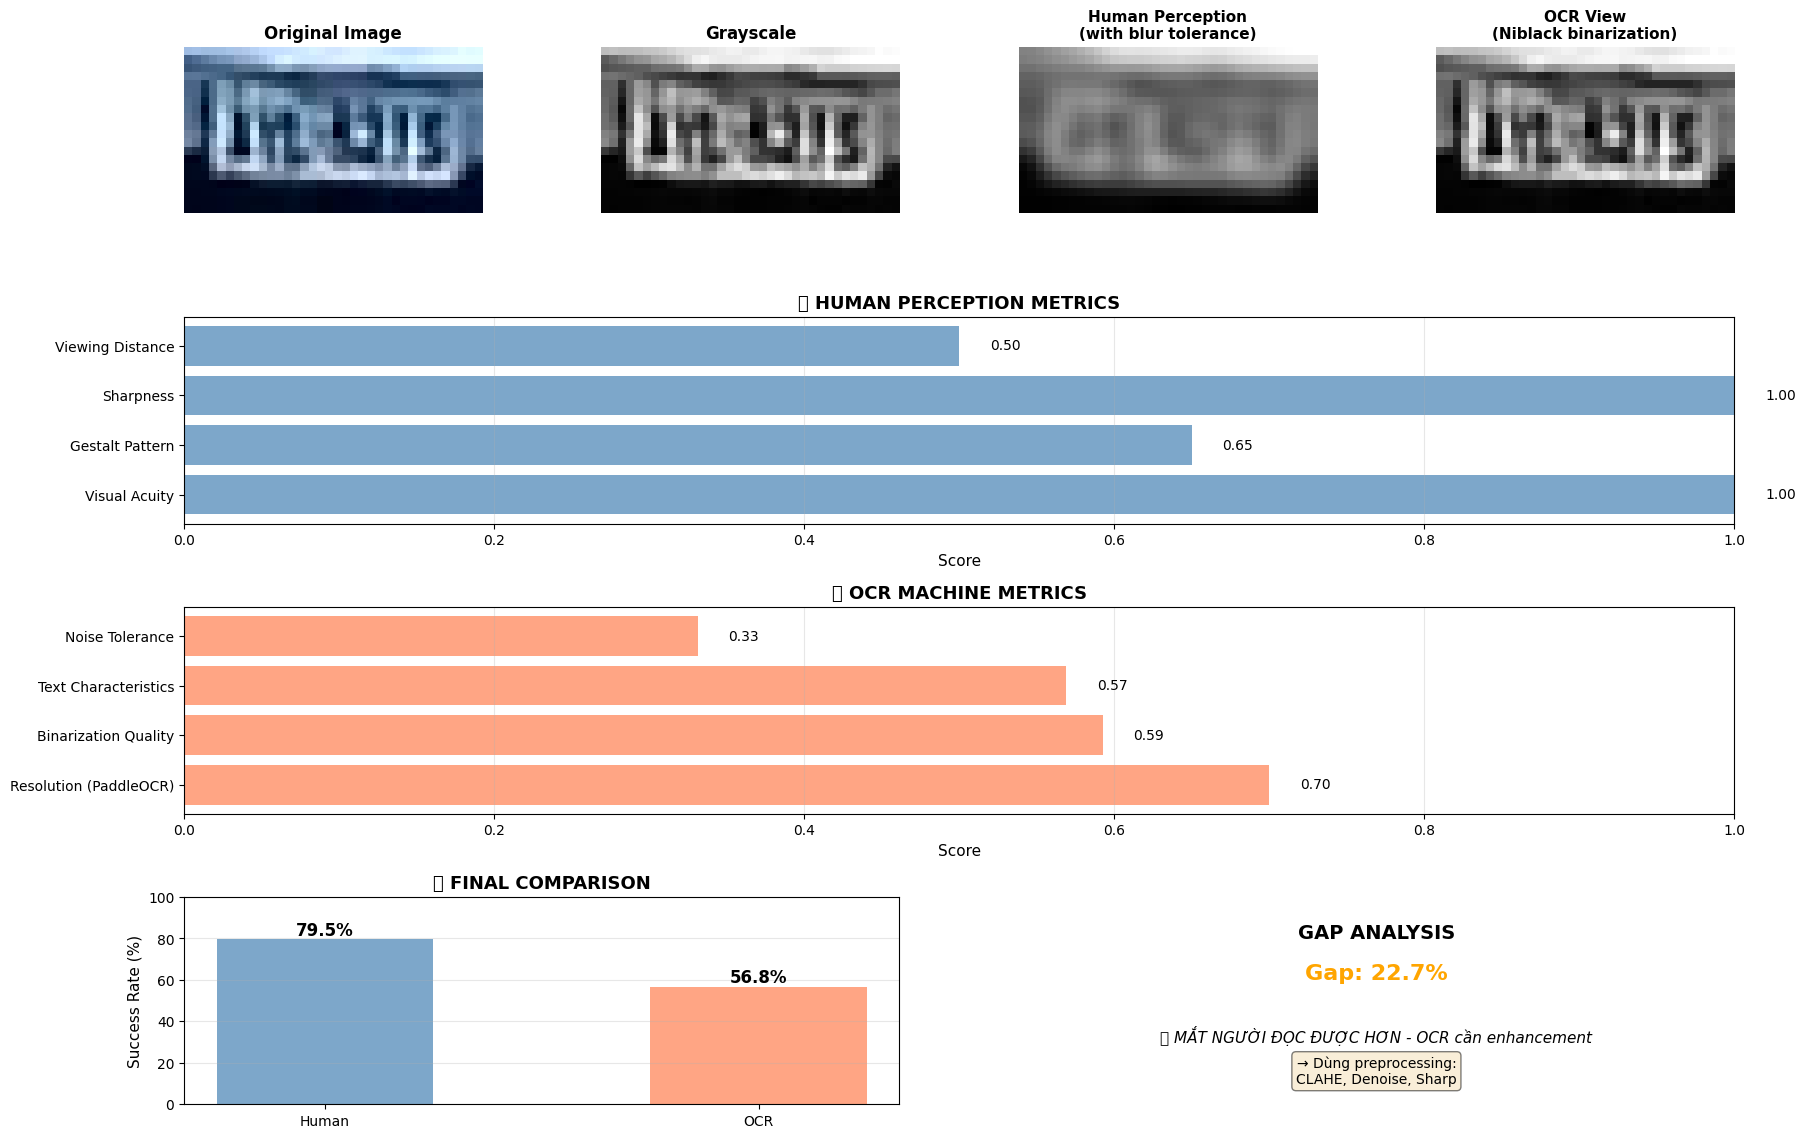

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal
from skimage import feature
import warnings
warnings.filterwarnings('ignore')

class DualReadabilityChecker:
    """
    Kiểm tra khả năng đọc được từ 2 góc độ:
    1. Human Perception - Mắt người
    2. OCR Machine - Mô hình OCR
    """
    
    def __init__(self, img_path=None, img_array=None):
        if img_path:
            self.original = cv2.imread(img_path)
            if self.original is None:
                raise ValueError(f"Không thể đọc ảnh từ {img_path}")
            self.original = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        elif img_array is not None:
            self.original = img_array
        else:
            raise ValueError("Cần cung cấp img_path hoặc img_array")
        
        self.gray = cv2.cvtColor(self.original, cv2.COLOR_RGB2GRAY)
        self.human_metrics = {}
        self.ocr_metrics = {}
        
    # ============ HUMAN PERCEPTION METRICS ============
    
    def check_human_visual_acuity(self):
        """
        Kiểm tra khả năng mắt người phân biệt được
        Dựa trên Contrast Sensitivity Function (CSF)
        """
        h, w = self.gray.shape
        
        # Tính spatial frequency (cycles per degree)
        # Giả sử xem ảnh từ khoảng cách 50cm, 1 pixel ≈ 0.02 degree
        viewing_distance = 50  # cm
        pixel_size = 0.02  # degree per pixel (ước tính)
        
        # Tần số không gian trung bình của text
        # Text thường có frequency ~3-8 cycles/degree
        estimated_text_freq = 1 / (max(h, w) * pixel_size)  # cycles/degree
        
        # Human CSF peak ở ~4 cycles/degree
        optimal_freq = 4.0
        csf_sensitivity = np.exp(-((estimated_text_freq - optimal_freq) ** 2) / (2 * 2.0 ** 2))
        
        # Tính Michelson contrast
        I_max = np.max(self.gray)
        I_min = np.min(self.gray)
        michelson_contrast = (I_max - I_min) / (I_max + I_min + 1e-10)
        
        # Weber contrast (cho text trên background)
        background = np.median(self.gray)
        foreground_mask = self.gray < (background - 20)
        if np.any(foreground_mask):
            foreground = np.mean(self.gray[foreground_mask])
            weber_contrast = abs(foreground - background) / (background + 1e-10)
        else:
            weber_contrast = 0
        
        # Human contrast threshold ~0.01-0.02 (1-2%)
        # Text cần Weber contrast > 0.15 để đọc dễ
        human_readable_contrast = weber_contrast > 0.15
        
        result = {
            'spatial_frequency': estimated_text_freq,
            'csf_sensitivity': csf_sensitivity,
            'michelson_contrast': michelson_contrast,
            'weber_contrast': weber_contrast,
            'meets_human_threshold': human_readable_contrast and csf_sensitivity > 0.3,
            'readability_score': min(csf_sensitivity * weber_contrast * 10, 1.0)
        }
        
        self.human_metrics['visual_acuity'] = result
        return result
    
    def check_gestalt_principles(self):
        """
        Kiểm tra nguyên lý Gestalt - Mắt người nhận dạng pattern
        - Proximity: Các pixels gần nhau tạo thành nhóm
        - Continuity: Đường nét liên tục
        - Closure: Khả năng "fill in" phần thiếu
        """
        # Detect connected components
        _, binary = cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
        
        # Lọc components quá nhỏ hoặc quá lớn
        min_area = 5
        max_area = self.gray.size * 0.3
        valid_components = []
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if min_area < area < max_area:
                valid_components.append(i)
        
        # Continuity: Đo độ liên tục của edges
        edges = cv2.Canny(self.gray, 30, 100)
        
        # Hough transform để tìm lines (text có nhiều lines song song)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=10, 
                                minLineLength=5, maxLineGap=3)
        line_count = len(lines) if lines is not None else 0
        
        # Closure: Đo khả năng form closed shapes (letters)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        closed_shapes = len([c for c in contours if cv2.contourArea(c) > 10])
        
        # Gestalt score
        gestalt_score = (
            min(len(valid_components) / 8, 1.0) * 0.4 +  # Có đủ components
            min(line_count / 5, 1.0) * 0.3 +  # Có lines
            min(closed_shapes / 6, 1.0) * 0.3  # Có closed shapes
        )
        
        result = {
            'num_components': len(valid_components),
            'num_lines': line_count,
            'num_closed_shapes': closed_shapes,
            'gestalt_score': gestalt_score,
            'has_recognizable_pattern': gestalt_score > 0.4
        }
        
        self.human_metrics['gestalt'] = result
        return result
    
    def check_blur_perception(self):
        """
        Kiểm tra mức độ blur - Mắt người rất nhạy với blur
        Sử dụng Laplacian variance
        """
        # Laplacian variance - standard method
        laplacian = cv2.Laplacian(self.gray, cv2.CV_64F)
        blur_score = laplacian.var()
        
        # Gradient magnitude
        sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
        edge_sharpness = np.mean(gradient_magnitude)
        
        # FFT-based blur detection
        f = np.fft.fft2(self.gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.abs(fshift)
        
        # High frequency energy ratio
        rows, cols = self.gray.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols))
        r = min(rows, cols) // 4
        y, x = np.ogrid[:rows, :cols]
        mask_area = (x - ccol)**2 + (y - crow)**2 <= r*r
        mask[mask_area] = 1
        
        low_freq_energy = np.sum(magnitude_spectrum * mask)
        high_freq_energy = np.sum(magnitude_spectrum * (1 - mask))
        freq_ratio = high_freq_energy / (low_freq_energy + high_freq_energy + 1e-10)
        
        # Human perception of blur
        # Blur_score > 100: Sharp
        # Blur_score < 50: Blurry
        is_sharp_to_human = blur_score > 50 and freq_ratio > 0.3
        
        result = {
            'laplacian_variance': blur_score,
            'edge_sharpness': edge_sharpness,
            'high_freq_ratio': freq_ratio,
            'is_sharp': is_sharp_to_human,
            'perceived_blur_level': self._blur_level(blur_score)
        }
        
        self.human_metrics['blur'] = result
        return result
    
    def _blur_level(self, score):
        if score > 500:
            return "Very Sharp"
        elif score > 200:
            return "Sharp"
        elif score > 100:
            return "Acceptable"
        elif score > 50:
            return "Blurry"
        else:
            return "Very Blurry"
    
    def check_viewing_distance_effect(self):
        """
        Mắt người có thể đọc được khi zoom out (xa hơn)
        Simulate viewing từ xa bằng cách downscale rồi upscale
        """
        h, w = self.gray.shape
        
        # Simulate xem từ xa (squinting effect)
        scales = [1.0, 0.5, 0.25]  # Normal, 2x xa, 4x xa
        readabilities = []
        
        for scale in scales:
            if scale < 1.0:
                # Downscale
                small = cv2.resize(self.gray, None, fx=scale, fy=scale, 
                                  interpolation=cv2.INTER_AREA)
                # Upscale lại
                resized = cv2.resize(small, (w, h), interpolation=cv2.INTER_CUBIC)
            else:
                resized = self.gray
            
            # Đo contrast ở scale này
            _, binary = cv2.threshold(resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            edges = cv2.Canny(binary, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size
            readabilities.append(edge_density)
        
        # Tìm scale tốt nhất
        best_scale_idx = np.argmax(readabilities)
        best_scale = scales[best_scale_idx]
        
        # Nếu scale nhỏ hơn 1.0 đọc được tốt hơn → cần zoom out
        needs_zoom_out = best_scale < 1.0
        
        result = {
            'readability_at_scales': dict(zip(scales, readabilities)),
            'best_viewing_scale': best_scale,
            'needs_zoom_out': needs_zoom_out,
            'zoom_out_helps': readabilities[1] > readabilities[0] * 1.2 if len(readabilities) > 1 else False
        }
        
        self.human_metrics['viewing_distance'] = result
        return result
    
    # ============ OCR MACHINE METRICS ============
    
    def check_ocr_resolution_requirements(self):
        """
        Yêu cầu resolution cho OCR engines
        - Tesseract: Khuyến nghị 300 DPI, tối thiểu ~20-30 pixels chiều cao
        - EasyOCR: ~25-35 pixels
        - PaddleOCR: ~16-20 pixels (tốt với text nhỏ hơn)
        """
        h, w = self.gray.shape
        
        # Ước tính số ký tự
        estimated_chars = max(w // 3, 1)  # Giả sử mỗi char ~3-5 pixels width
        pixels_per_char_height = h
        pixels_per_char_width = w / estimated_chars
        
        # OCR engine requirements
        requirements = {
            'Tesseract': {'min_height': 20, 'recommended_height': 30},
            'EasyOCR': {'min_height': 25, 'recommended_height': 35},
            'PaddleOCR': {'min_height': 16, 'recommended_height': 24},
            'TrOCR': {'min_height': 32, 'recommended_height': 48}  # Transformer-based
        }
        
        compatibility = {}
        for engine, req in requirements.items():
            meets_min = pixels_per_char_height >= req['min_height']
            meets_rec = pixels_per_char_height >= req['recommended_height']
            compatibility[engine] = {
                'meets_minimum': meets_min,
                'meets_recommended': meets_rec,
                'success_probability': self._estimate_ocr_probability(
                    pixels_per_char_height, req['min_height'], req['recommended_height']
                )
            }
        
        result = {
            'resolution': (h, w),
            'pixels_per_char': pixels_per_char_height,
            'engine_compatibility': compatibility,
            'best_engine': max(compatibility.items(), 
                             key=lambda x: x[1]['success_probability'])[0]
        }
        
        self.ocr_metrics['resolution'] = result
        return result
    
    def _estimate_ocr_probability(self, current, minimum, recommended):
        if current >= recommended:
            return 0.9
        elif current >= minimum:
            # Linear interpolation
            return 0.5 + 0.4 * (current - minimum) / (recommended - minimum)
        else:
            # Exponential decay below minimum
            return 0.5 * np.exp(-2 * (minimum - current) / minimum)
    
    def check_ocr_binarization_quality(self):
        """
        OCR machines rất phụ thuộc vào binarization tốt
        Kiểm tra xem có thể binarize tốt không
        """
        # Thử nhiều phương pháp binarization
        methods = {}
        
        # 1. Otsu
        _, otsu = cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        methods['Otsu'] = otsu
        
        # 2. Adaptive Gaussian
        adaptive = cv2.adaptiveThreshold(self.gray, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
        methods['Adaptive'] = adaptive
        
        # 3. Niblack-like
        window_size = min(15, min(self.gray.shape) // 3)
        if window_size % 2 == 0:
            window_size += 1
        if window_size >= 3:
            mean = cv2.boxFilter(self.gray.astype(np.float64), -1, (window_size, window_size))
            threshold = mean - 10
            niblack = (self.gray > threshold).astype(np.uint8) * 255
            methods['Niblack'] = niblack
        
        # Đánh giá quality của mỗi binarization
        quality_scores = {}
        for name, binary in methods.items():
            # Metrics for good binarization
            # 1. Foreground/Background ratio (should be ~0.2-0.4 for text)
            fg_ratio = np.sum(binary == 0) / binary.size
            fg_score = 1 - abs(fg_ratio - 0.3) / 0.3 if fg_ratio < 0.6 else 0
            
            # 2. Connected components (should have ~5-10 for license plate)
            num_labels, _, stats, _ = cv2.connectedComponentsWithStats(
                cv2.bitwise_not(binary), connectivity=8)
            valid_components = sum(1 for i in range(1, num_labels) 
                                 if 10 < stats[i, cv2.CC_STAT_AREA] < binary.size * 0.3)
            comp_score = min(valid_components / 8, 1.0)
            
            # 3. Edge preservation
            edges_original = cv2.Canny(self.gray, 50, 150)
            edges_binary = cv2.Canny(binary, 50, 150)
            edge_preservation = np.sum(edges_binary > 0) / (np.sum(edges_original > 0) + 1)
            edge_score = min(edge_preservation, 1.0)
            
            quality = fg_score * 0.3 + comp_score * 0.4 + edge_score * 0.3
            quality_scores[name] = {
                'quality': quality,
                'fg_ratio': fg_ratio,
                'num_components': valid_components,
                'edge_preservation': edge_preservation
            }
        
        best_method = max(quality_scores.items(), key=lambda x: x[1]['quality'])
        
        result = {
            'methods_tested': list(methods.keys()),
            'quality_scores': quality_scores,
            'best_method': best_method[0],
            'best_quality': best_method[1]['quality'],
            'can_binarize_well': best_method[1]['quality'] > 0.5
        }
        
        self.ocr_metrics['binarization'] = result
        return result
    
    def check_ocr_text_characteristics(self):
        """
        Kiểm tra các đặc điểm text mà OCR cần:
        - Uniform stroke width
        - Regular spacing
        - Consistent orientation
        """
        # Canny edges
        edges = cv2.Canny(self.gray, 50, 150)
        
        # Stroke width variation
        # OCR tốt khi stroke width đồng đều
        distance_transform = cv2.distanceTransform(cv2.bitwise_not(
            cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        ), cv2.DIST_L2, 3)
        
        stroke_widths = distance_transform[distance_transform > 0]
        if len(stroke_widths) > 0:
            stroke_mean = np.mean(stroke_widths)
            stroke_std = np.std(stroke_widths)
            stroke_uniformity = 1 - min(stroke_std / (stroke_mean + 1e-10), 1)
        else:
            stroke_uniformity = 0
        
        # Character spacing (horizontal projection)
        horizontal_proj = np.sum(edges, axis=0)
        # Tìm peaks (characters) và valleys (spaces)
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(horizontal_proj, distance=2)
        spacing_uniformity = 0
        if len(peaks) > 1:
            spacings = np.diff(peaks)
            spacing_std = np.std(spacings)
            spacing_mean = np.mean(spacings)
            spacing_uniformity = 1 - min(spacing_std / (spacing_mean + 1e-10), 1)
        
        # Text orientation (should be horizontal for most OCR)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=10,
                               minLineLength=5, maxLineGap=3)
        orientations = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
                orientations.append(angle)
        
        orientation_consistency = 0
        if len(orientations) > 0:
            # Text tốt khi góc gần 0° hoặc 90°
            angles_from_horizontal = [min(abs(a), abs(a - 180)) for a in orientations]
            orientation_consistency = 1 - np.std(angles_from_horizontal) / 45
            orientation_consistency = max(0, orientation_consistency)
        
        result = {
            'stroke_uniformity': stroke_uniformity,
            'spacing_uniformity': spacing_uniformity,
            'orientation_consistency': orientation_consistency,
            'ocr_friendly_score': (stroke_uniformity * 0.4 + 
                                  spacing_uniformity * 0.3 + 
                                  orientation_consistency * 0.3),
            'is_ocr_friendly': (stroke_uniformity > 0.4 and 
                               spacing_uniformity > 0.3 and 
                               orientation_consistency > 0.4)
        }
        
        self.ocr_metrics['text_characteristics'] = result
        return result
    
    def check_ocr_noise_tolerance(self):
        """
        OCR machines kém tolerance với noise hơn mắt người
        """
        # Estimate noise level
        # Sử dụng median filter để ước tính noise
        median_filtered = cv2.medianBlur(self.gray, 3)
        noise = np.abs(self.gray.astype(float) - median_filtered.astype(float))
        noise_level = np.mean(noise)
        noise_std = np.std(noise)
        
        # Signal-to-Noise Ratio
        signal = np.mean(self.gray)
        snr = signal / (noise_level + 1e-10)
        
        # OCR cần SNR > 10 để hoạt động tốt
        good_snr = snr > 10
        
        # Noise pattern analysis
        # Salt & pepper noise vs Gaussian noise
        unique_values = len(np.unique(self.gray))
        is_quantized = unique_values < 50  # Ít unique values → có thể là compressed/quantized
        
        result = {
            'noise_level': noise_level,
            'noise_std': noise_std,
            'snr': snr,
            'is_low_noise': good_snr,
            'is_quantized': is_quantized,
            'ocr_noise_tolerance': min(snr / 20, 1.0)  # Normalize to 0-1
        }
        
        self.ocr_metrics['noise'] = result
        return result
    
    # ============ COMPARISON & ANALYSIS ============
    
    def run_all_checks(self):
        """Chạy tất cả các kiểm tra"""
        print("Đang phân tích HUMAN PERCEPTION...")
        self.check_human_visual_acuity()
        self.check_gestalt_principles()
        self.check_blur_perception()
        self.check_viewing_distance_effect()
        
        print("Đang phân tích OCR MACHINE CAPABILITY...")
        self.check_ocr_resolution_requirements()
        self.check_ocr_binarization_quality()
        self.check_ocr_text_characteristics()
        self.check_ocr_noise_tolerance()
        
        print("Hoàn thành!")
        return self.human_metrics, self.ocr_metrics
    
    def calculate_final_scores(self):
        """Tính điểm tổng hợp cho Human và OCR"""
        if not self.human_metrics or not self.ocr_metrics:
            self.run_all_checks()
        
        # Human Score
        human_score = (
            self.human_metrics['visual_acuity']['readability_score'] * 0.3 +
            self.human_metrics['gestalt']['gestalt_score'] * 0.3 +
            (1 if self.human_metrics['blur']['is_sharp'] else 0.3) * 0.2 +
            (0.8 if self.human_metrics['viewing_distance']['zoom_out_helps'] else 0.5) * 0.2
        )
        
        # OCR Score
        best_engine_prob = max(
            self.ocr_metrics['resolution']['engine_compatibility'].values(),
            key=lambda x: x['success_probability']
        )['success_probability']
        
        ocr_score = (
            best_engine_prob * 0.3 +
            self.ocr_metrics['binarization']['best_quality'] * 0.3 +
            self.ocr_metrics['text_characteristics']['ocr_friendly_score'] * 0.2 +
            self.ocr_metrics['noise']['ocr_noise_tolerance'] * 0.2
        )
        
        # Gap analysis
        gap = human_score - ocr_score
        
        return {
            'human_score': human_score * 100,
            'ocr_score': ocr_score * 100,
            'gap': gap * 100,
            'interpretation': self._interpret_gap(gap)
        }
    
    def _interpret_gap(self, gap):
        if gap > 0.3:
            return "🔴 MẮT NGƯỜI ĐỌC ĐƯỢC nhưng OCR KHÓ - Cần preprocessing mạnh"
        elif gap > 0.1:
            return "🟡 MẮT NGƯỜI ĐỌC ĐƯỢC HƠN - OCR cần enhancement"
        elif gap > -0.1:
            return "🟢 TƯƠNG ĐƯƠNG - Cả hai đều có khả năng tương tự"
        elif gap > -0.3:
            return "🔵 OCR TỐT HƠN MẮT NGƯỜI - Binarization giúp OCR"
        else:
            return "🟣 OCR RẤT TỐT - Machine vision vượt trội"
    
    def visualize_comparison(self, figsize=(20, 14)):
        """Visualize so sánh Human vs OCR"""
        if not self.human_metrics or not self.ocr_metrics:
            self.run_all_checks()
        
        scores = self.calculate_final_scores()
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.4)
        
        # Row 1: Original + Processing examples
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(self.original)
        ax1.set_title('Original Image', fontweight='bold', fontsize=12)
        ax1.axis('off')
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(self.gray, cmap='gray')
        ax2.set_title('Grayscale', fontweight='bold', fontsize=12)
        ax2.axis('off')
        
        # Blur simulation (human perception)
        ax3 = fig.add_subplot(gs[0, 2])
        blurred = cv2.GaussianBlur(self.gray, (5, 5), 1.5)
        ax3.imshow(blurred, cmap='gray')
        ax3.set_title('Human Perception\n(with blur tolerance)', fontweight='bold', fontsize=11)
        ax3.axis('off')
        
        # Best binarization (OCR)
        ax4 = fig.add_subplot(gs[0, 3])
        best_method = self.ocr_metrics['binarization']['best_method']
        if best_method == 'Otsu':
            _, binary = cv2.threshold(self.gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif best_method == 'Adaptive':
            binary = cv2.adaptiveThreshold(self.gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
        else:
            binary = self.gray
        ax4.imshow(binary, cmap='gray')
        ax4.set_title(f'OCR View\n({best_method} binarization)', fontweight='bold', fontsize=11)
        ax4.axis('off')
        
        # Row 2: Human Metrics
        ax5 = fig.add_subplot(gs[1, :])
        human_metrics_display = {
            'Visual Acuity': self.human_metrics['visual_acuity']['readability_score'],
            'Gestalt Pattern': self.human_metrics['gestalt']['gestalt_score'],
            'Sharpness': 1 if self.human_metrics['blur']['is_sharp'] else 0.3,
            'Viewing Distance': 0.8 if self.human_metrics['viewing_distance']['zoom_out_helps'] else 0.5
        }
        
        bars = ax5.barh(list(human_metrics_display.keys()), 
                       list(human_metrics_display.values()),
                       color='steelblue', alpha=0.7)
        ax5.set_xlim(0, 1)
        ax5.set_xlabel('Score', fontsize=11)
        ax5.set_title('👁️ HUMAN PERCEPTION METRICS', fontweight='bold', fontsize=13)
        ax5.grid(axis='x', alpha=0.3)
        
        for i, (k, v) in enumerate(human_metrics_display.items()):
            ax5.text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=10)
        
        # Row 3: OCR Metrics
        ax6 = fig.add_subplot(gs[2, :])
        best_engine = self.ocr_metrics['resolution']['best_engine']
        ocr_metrics_display = {
            f'Resolution ({best_engine})': self.ocr_metrics['resolution']['engine_compatibility'][best_engine]['success_probability'],
            'Binarization Quality': self.ocr_metrics['binarization']['best_quality'],
            'Text Characteristics': self.ocr_metrics['text_characteristics']['ocr_friendly_score'],
            'Noise Tolerance': self.ocr_metrics['noise']['ocr_noise_tolerance']
        }
        
        bars = ax6.barh(list(ocr_metrics_display.keys()), 
                       list(ocr_metrics_display.values()),
                       color='coral', alpha=0.7)
        ax6.set_xlim(0, 1)
        ax6.set_xlabel('Score', fontsize=11)
        ax6.set_title('🤖 OCR MACHINE METRICS', fontweight='bold', fontsize=13)
        ax6.grid(axis='x', alpha=0.3)
        
        for i, (k, v) in enumerate(ocr_metrics_display.items()):
            ax6.text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=10)
        
        # Row 4: Comparison
        ax7 = fig.add_subplot(gs[3, 0:2])
        categories = ['Human', 'OCR']
        scores_list = [scores['human_score'], scores['ocr_score']]
        colors = ['steelblue', 'coral']
        
        bars = ax7.bar(categories, scores_list, color=colors, alpha=0.7, width=0.5)
        ax7.set_ylim(0, 100)
        ax7.set_ylabel('Success Rate (%)', fontsize=11)
        ax7.set_title('📊 FINAL COMPARISON', fontweight='bold', fontsize=13)
        ax7.grid(axis='y', alpha=0.3)
        
        for bar, score in zip(bars, scores_list):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2, height + 2,
                    f'{score:.1f}%', ha='center', fontsize=12, fontweight='bold')
        
        # Gap analysis
        ax8 = fig.add_subplot(gs[3, 2:])
        ax8.text(0.5, 0.8, 'GAP ANALYSIS', ha='center', fontsize=14, fontweight='bold')
        ax8.text(0.5, 0.6, f"Gap: {scores['gap']:.1f}%", ha='center', fontsize=16,
                color='green' if abs(scores['gap']) < 10 else 'orange' if abs(scores['gap']) < 30 else 'red',
                fontweight='bold')
        ax8.text(0.5, 0.3, scores['interpretation'], ha='center', fontsize=11,
                wrap=True, style='italic')
        
        # Recommendation
        if scores['gap'] > 10:
            recommendation = "→ Dùng preprocessing:\nCLAHE, Denoise, Sharp"
        elif scores['gap'] < -10:
            recommendation = "→ OCR trực tiếp,\nkhông cần preprocessing"
        else:
            recommendation = "→ Thử cả hai cách:\nPreprocessing nhẹ"
        
        ax8.text(0.5, 0.1, recommendation, ha='center', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax8.set_xlim(0, 1)
        ax8.set_ylim(0, 1)
        ax8.axis('off')
        
        plt.savefig('human_vs_ocr_analysis.png', dpi=150, bbox_inches='tight')
        print("Đã lưu so sánh vào 'human_vs_ocr_analysis.png'")
        plt.show()
    
    def print_detailed_report(self):
        """In báo cáo chi tiết"""
        if not self.human_metrics or not self.ocr_metrics:
            self.run_all_checks()
        
        scores = self.calculate_final_scores()
        
        print("\n" + "="*90)
        print("BÁO CÁO SO SÁNH: HUMAN PERCEPTION vs OCR MACHINE")
        print("="*90)
        
        print("\n👁️  HUMAN PERCEPTION ANALYSIS:")
        print("-" * 90)
        
        va = self.human_metrics['visual_acuity']
        print(f"  Visual Acuity:")
        print(f"    • Weber Contrast: {va['weber_contrast']:.3f} {'✅' if va['weber_contrast'] > 0.15 else '❌'} (need > 0.15)")
        print(f"    • CSF Sensitivity: {va['csf_sensitivity']:.3f}")
        print(f"    • Readable: {'✅ Yes' if va['meets_human_threshold'] else '❌ No'}")
        
        gestalt = self.human_metrics['gestalt']
        print(f"\n  Gestalt Pattern Recognition:")
        print(f"    • Components: {gestalt['num_components']}")
        print(f"    • Lines detected: {gestalt['num_lines']}")
        print(f"    • Closed shapes: {gestalt['num_closed_shapes']}")
        print(f"    • Pattern recognizable: {'✅ Yes' if gestalt['has_recognizable_pattern'] else '❌ No'}")
        
        blur = self.human_metrics['blur']
        print(f"\n  Blur Perception:")
        print(f"    • Laplacian variance: {blur['laplacian_variance']:.1f}")
        print(f"    • Level: {blur['perceived_blur_level']}")
        print(f"    • Sharp enough: {'✅ Yes' if blur['is_sharp'] else '❌ No'}")
        
        viewing = self.human_metrics['viewing_distance']
        print(f"\n  Viewing Distance Effect:")
        print(f"    • Best scale: {viewing['best_viewing_scale']:.2f}x")
        print(f"    • Zoom out helps: {'✅ Yes' if viewing['zoom_out_helps'] else '❌ No'}")
        
        print("\n" + "="*90)
        print("\n🤖 OCR MACHINE ANALYSIS:")
        print("-" * 90)
        
        res = self.ocr_metrics['resolution']
        print(f"  Resolution Requirements:")
        print(f"    • Image size: {res['resolution'][0]}h x {res['resolution'][1]}w")
        print(f"    • Pixels per char: {res['pixels_per_char']:.1f}px")
        print(f"    • Best engine: {res['best_engine']}")
        print(f"    • Engine compatibility:")
        for engine, compat in res['engine_compatibility'].items():
            prob = compat['success_probability']
            status = '✅' if prob > 0.7 else '⚠️' if prob > 0.4 else '❌'
            print(f"      {status} {engine}: {prob:.1%}")
        
        binarization = self.ocr_metrics['binarization']
        print(f"\n  Binarization Quality:")
        print(f"    • Best method: {binarization['best_method']}")
        print(f"    • Quality score: {binarization['best_quality']:.3f}")
        print(f"    • Can binarize well: {'✅ Yes' if binarization['can_binarize_well'] else '❌ No'}")
        
        text_char = self.ocr_metrics['text_characteristics']
        print(f"\n  Text Characteristics:")
        print(f"    • Stroke uniformity: {text_char['stroke_uniformity']:.3f}")
        print(f"    • Spacing uniformity: {text_char['spacing_uniformity']:.3f}")
        print(f"    • Orientation consistency: {text_char['orientation_consistency']:.3f}")
        print(f"    • OCR friendly: {'✅ Yes' if text_char['is_ocr_friendly'] else '❌ No'}")
        
        noise = self.ocr_metrics['noise']
        print(f"\n  Noise Tolerance:")
        print(f"    • SNR: {noise['snr']:.1f} {'✅' if noise['is_low_noise'] else '❌'} (need > 10)")
        print(f"    • Noise level: {noise['noise_level']:.2f}")
        
        print("\n" + "="*90)
        print("\n📊 FINAL SCORES:")
        print("-" * 90)
        print(f"  👁️  Human Perception Score:  {scores['human_score']:.1f}%")
        print(f"  🤖 OCR Machine Score:       {scores['ocr_score']:.1f}%")
        print(f"  📏 Gap:                     {scores['gap']:.1f}%")
        print(f"\n  {scores['interpretation']}")
        
        print("\n" + "="*90)
        print("\n💡 RECOMMENDATIONS:")
        print("-" * 90)
        
        if scores['gap'] > 30:
            print("  🔴 MẮT NGƯỜI ĐỌC ĐƯỢC TỐT HƠN NHIỀU:")
            print("     → OCR cần preprocessing mạnh")
            print("     → Sử dụng: CLAHE + Adaptive Threshold + Morphology")
            print("     → Xem xét multi-scale enhancement")
            print("     → Có thể cần manual correction")
        elif scores['gap'] > 10:
            print("  🟡 MẮT NGƯỜI ĐỌC ĐƯỢC HƠN:")
            print("     → OCR cần preprocessing vừa phải")
            print("     → Sử dụng: Denoise + CLAHE + Sharpening")
            print("     → Thử nhiều OCR engines")
        elif scores['gap'] > -10:
            print("  🟢 TƯƠNG ĐƯƠNG:")
            print("     → Có thể OCR trực tiếp")
            print("     → Preprocessing nhẹ để tối ưu")
            print("     → Chọn OCR engine phù hợp với resolution")
        else:
            print("  🔵 OCR TỐT HƠN:")
            print("     → Binarization giúp OCR rất nhiều")
            print("     → Không cần preprocessing phức tạp")
            print("     → Chỉ cần binarization tốt")
        
        if self.human_metrics['viewing_distance']['zoom_out_helps']:
            print("\n  ℹ️  LƯU Ý: Zoom out giúp mắt người đọc tốt hơn")
            print("     → Đây là hiệu ứng tâm lý, không giúp OCR")
            print("     → Cần enhance để tạo thông tin tương tự cho OCR")
        
        print("\n" + "="*90 + "\n")


# Ví dụ sử dụng
if __name__ == "__main__":
    # print("="*90)
    # print("DEMO: SO SÁNH HUMAN PERCEPTION vs OCR MACHINE")
    # print("="*90)
    
    # # Tạo 3 loại ảnh demo
    # print("\nTạo ảnh demo...")
    
    # # 1. Ảnh nhỏ nhưng contrast cao - Human OK, OCR struggle
    # demo1 = np.ones((18, 30, 3), dtype=np.uint8) * 240
    # cv2.putText(demo1, '29A', (2, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
    # cv2.putText(demo1, '12345', (2, 16), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 0, 0), 1)
    # noise = np.random.normal(0, 8, demo1.shape)
    # demo1 = np.clip(demo1 + noise, 0, 255).astype(np.uint8)
    
    print("\n" + "="*90)
    print("CASE 1: Ảnh nhỏ (18x30) - Contrast tốt")
    print("="*90)
    checker1 = DualReadabilityChecker(img_path="/home/thiendc/projects/icpr/dataset/train/Scenario-A/Brazilian/track_00001/lr-005.png")
    checker1.run_all_checks()
    checker1.print_detailed_report()
    checker1.visualize_comparison()
    
    # print("\n" + "="*90)
    # print("TỔNG KẾT")
    # print("="*90)
    # print("✅ Tool này giúp bạn hiểu:")
    # print("   1. Tại sao MẮT NGƯỜI nhìn thấy nhưng OCR KHÔNG đọc được")
    # print("   2. Metrics nào quan trọng cho từng loại (Human vs Machine)")
    # print("   3. Cách preprocessing phù hợp dựa trên GAP")
    # print("\n💡 Nguyên tắc:")
    # print("   • Gap > 10%: Cần preprocessing cho OCR")
    # print("   • Gap < -10%: Binarization đủ rồi")
    # print("   • Gap ≈ 0: Cả hai đều OK hoặc đều khó")
    # print("="*90)